In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-Myositis-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Presynoviomics-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20210621-DataSheet-RUN41-human-BCRh-UMI.csv"
run = "run41"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run41-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,E2134-17-B4_S215,AGTCAGTC,CATTFISGTTGYWGQGTLVT,7252,402,IGHV3-7,IGHJ4,81,0.011169,44.534512,27.272727
1,E2134-17-B4_S215,AGTCAGTC,CAKREGYRQNWFAPWGQGTLVT,3161,205,IGHV3-23,"IGHJ5,IGHJ4",6263,1.981335,19.411692,13.907734
2,E2134-17-B4_S215,AGTCAGTC,CARDHTETLFYYYYMGVWGKGTTVT,919,52,IGHV3-7,IGHJ6,0,0.000000,5.643577,3.527815
3,E2134-17-B4_S215,AGTCAGTC,CARAAAGLDYWGQGNLVT,448,33,IGHV3-72,IGHJ4,2,0.004464,2.751167,2.238806
4,E2134-17-B4_S215,AGTCAGTC,CASDPPNSNYAFHNWGQGTLVT,383,32,IGHV3-30,IGHJ4,0,0.000000,2.352002,2.170963


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
1183426,MYO201week52-B2_S214,CARATDCSDTSCYAVKWFDPWGQGTLVT,524,369,7,0.013359,0.829613,0.889886
1193759,MYO201week52-B2_S214,CARGYFGPDGFDLWGQGTMVT,416,239,382,0.918269,0.658624,0.576376
1185081,MYO201week52-B2_S214,CARDKGFWSGYDYFDYWGQGTLVT,299,195,9,0.030100,0.473386,0.470265
1182251,MYO201week52-B2_S214,CARAEYSSGWYFDYWGQGTLVT,198,123,10,0.050505,0.313480,0.296629
1199405,MYO201week52-B2_S214,CARVIKFSPVGMPTGFDYWGQGTLVT,171,109,1,0.005848,0.270732,0.262866


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,Constant,HEK_cells,RACE,MID
0,N711_S502,BB3845-LN-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S9,Presynoviomics,human,BCRh,BB3845,LN,yes,no,yes,no,NaN
1,N712_S502,BB4554-PB-2-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10,Presynoviomics,human,BCRh,BB4554,PB,yes,no,yes,no,NaN
2,N714_S502,BB3570-LN-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S11,Presynoviomics,human,BCRh,BB3570,LN,yes,no,yes,no,NaN
3,N715_S502,BB3844-LN-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S12,Presynoviomics,human,BCRh,BB3844,LN,yes,no,yes,no,NaN
4,N716_S502,BB3843-LN-B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S13,Presynoviomics,human,BCRh,BB3843,LN,yes,no,yes,no,NaN


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,BB3845-LN-B_S9,BB3845
1,BB4554-PB-2-B_S10,BB4554
2,BB3570-LN-B_S11,BB3570
3,BB3844-LN-B_S12,BB3844
4,BB3843-LN-B_S13,BB3843


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,MYO201week52-B2_S214,CARATDCSDTSCYAVKWFDPWGQGTLVT,524,369,7,0.013359,0.829613,0.889886,MYO201
1,MYO201week52-B2_S214,CARGYFGPDGFDLWGQGTMVT,416,239,382,0.918269,0.658624,0.576376,MYO201
2,MYO201week52-B2_S214,CARDKGFWSGYDYFDYWGQGTLVT,299,195,9,0.030100,0.473386,0.470265,MYO201
3,MYO201week52-B2_S214,CARAEYSSGWYFDYWGQGTLVT,198,123,10,0.050505,0.313480,0.296629,MYO201
4,MYO201week52-B2_S214,CARVIKFSPVGMPTGFDYWGQGTLVT,171,109,1,0.005848,0.270732,0.262866,MYO201


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                             B11BB388          B13BB1203  \
Sample                     B11BB388-LN-B_S82 B13BB1203-LN-B_S83   
cdr3pep                                                           
AAAGNYYYYYGMDVWGQGTTVT                   0.0                0.0   
AAAGTGFDPWGQGTLVT                        0.0                0.0   
AARDYYDTSGYSRFDPWGQGTLVT                 0.0                0.0   
AARQRRHLESGEVFWFDPWGQGTLVT               0.0                0.0   
AASAPEAGTLYYYGMDVWGQGTTVT                0.0                0.0   

Patient                             B13V1           B13V5          B15BB931  \
Sample                     B13V1-PB-B_S22 B13V5-PB-B_S127 B15BB931-LN-B_S84   
cdr3pep                                                                       
AAAGNYYYYYGMDVWGQGTTVT                0.0             0.0               0.0   
AAAGTGFDPWGQGTLVT                     0.0             0.0               0.0   
AARDYYDTSGYSRFDPWGQGTLVT              0.0             0.0               0.0   
AARQRRHLESGEVFWFDPWGQGTLVT            0.0             0.0               0.0   
AASAPEAGTLYYYGMDVWGQGTTVT             0.0             0.0               0.0   

Patient                              B18V1           B18V7          B19V1  \
Sample                     B18V1-PB-B_S236 B18V7-PB-B_S237 B19V1-PB-B_S23   
cdr3pep                                                                     
AAAGNYYYYYGMDVWGQGTTVT                 0.0             0.0            0.0   
AAAGTGFDPWGQGTLVT                      0.0             0.0            0.0   
AARDYYDTSGYSRFDPWGQGTLVT               0.0             0.0            0.0   
AARQRRHLESGEVFWFDPWGQGTLVT             0.0             0.0            0.0   
AASAPEAGTLYYYGMDVWGQGTTVT              0.0             0.0            0.0   

Patient                              B1V1          B20V1         ...           \
Sample                     B1V1-PB-B_S170 B20V1-PB-B_S24         ...            
cdr3pep                                                          ...            
AAAGNYYYYYGMDVWGQGTTVT                0.0            0.0         ...            
AAAGTGFDPWGQGTLVT                     0.0            0.0         ...            
AARDYYDTSGYSRFDPWGQGTLVT              0.0            0.0         ...            
AARQRRHLESGEVFWFDPWGQGTLVT            0.0            0.0         ...            
AASAPEAGTLYYYGMDVWGQGTTVT             0.0            0.0         ...            

Patient                              BB6839           BB701           BB709  \
Sample                     BB6839-PB-B_S223 BB701-PB-B_S171 BB709-PB-B_S184   
cdr3pep                                                                       
AAAGNYYYYYGMDVWGQGTTVT                  0.0             0.0             0.0   
AAAGTGFDPWGQGTLVT                       0.0             0.0             0.0   
AARDYYDTSGYSRFDPWGQGTLVT                0.0             0.0             0.0   
AARQRRHLESGEVFWFDPWGQGTLVT              0.0             0.0             0.0   
AASAPEAGTLYYYGMDVWGQGTTVT               0.0             0.0             0.0   

Patient                              Bx1338           Bx1481          Bx1562  \
Sample                     Bx1338-ST-B_S233 Bx1481-ST-B_S230 Bx1562-ST-B_S67   
cdr3pep                                                                        
AAAGNYYYYYGMDVWGQGTTVT                  0.0              0.0             0.0   
AAAGTGFDPWGQGTLVT                       0.0              0.0             0.0   
AARDYYDTSGYSRFDPWGQGTLVT                0.0              0.0             0.0   
AARQRRHLESGEVFWFDPWGQGTLVT              0.0              0.0             0.0   
AASAPEAGTLYYYGMDVWGQGTTVT               0.0              0.0             0.0   

Patient                              MYO201                     \
Sample                     E2134-17-B4_S215 MYO201base-B2_S212   
cdr3pep                                                          
AAAGNYYYYYGMDVWGQGTTVT                  0.0                0.0   
AAAGTGFDPWGQGTLVT         

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                               B11BB388          B13BB1203  \
Sample                       B11BB388-LN-B_S82 B13BB1203-LN-B_S83   
Patient   Sample                                                    
B11BB388  B11BB388-LN-B_S82           1.000000           0.000027   
B13BB1203 B13BB1203-LN-B_S83          0.000027           1.000000   
B13V1     B13V1-PB-B_S22              0.000026           0.000081   
B13V5     B13V5-PB-B_S127             0.000000           0.000083   
B15BB931  B15BB931-LN-B_S84           0.000000           0.000040   

Patient                               B13V1           B13V5          B15BB931  \
Sample                       B13V1-PB-B_S22 B13V5-PB-B_S127 B15BB931-LN-B_S84   
Patient   Sample                                                                
B11BB388  B11BB388-LN-B_S82        0.000026        0.000000           0.00000   
B13BB1203 B13BB1203-LN-B_S83       0.000081        0.000083           0.00004   
B13V1     B13V1-PB-B_S22           1.000000        0.022726           0.00000   
B13V5     B13V5-PB-B_S127          0.022726        1.000000           0.00000   
B15BB931  B15BB931-LN-B_S84        0.000000        0.000000           1.00000   

Patient                                B18V1           B18V7          B19V1  \
Sample                       B18V1-PB-B_S236 B18V7-PB-B_S237 B19V1-PB-B_S23   
Patient   Sample                                                              
B11BB388  B11BB388-LN-B_S82         0.000025        0.000045       0.000114   
B13BB1203 B13BB1203-LN-B_S83        0.000115        0.000066       0.000155   
B13V1     B13V1-PB-B_S22            0.000000        0.000032       0.000176   
B13V5     B13V5-PB-B_S127           0.000000        0.000259       0.000025   
B15BB931  B15BB931-LN-B_S84         0.000036        0.000000       0.000025   

Patient                                B1V1          B20V1  \
Sample                       B1V1-PB-B_S170 B20V1-PB-B_S24   
Patient   Sample                                             
B11BB388  B11BB388-LN-B_S82        0.000180       0.000024   
B13BB1203 B13BB1203-LN-B_S83       0.000033       0.000073   
B13V1     B13V1-PB-B_S22           0.000000       0.000141   
B13V5     B13V5-PB-B_S127          0.000032       0.000000   
B15BB931  B15BB931-LN-B_S84        0.000123       0.000000   

Patient                              ...                    BB6839  \
Sample                               ...          BB6839-PB-B_S223   
Patient   Sample                     ...                             
B11BB388  B11BB388-LN-B_S82          ...                  0.000022   
B13BB1203 B13BB1203-LN-B_S83         ...                  0.000159   
B13V1     B13V1-PB-B_S22             ...                  0.000215   
B13V5     B13V5-PB-B_S127            ...                  0.000186   
B15BB931  B15BB931-LN-B_S84          ...                  0.000000   

Patient                                BB701           BB709           Bx1338  \
Sample                       BB701-PB-B_S171 BB709-PB-B_S184 Bx1338-ST-B_S233   
Patient   Sample                                                                
B11BB388  B11BB388-LN-B_S82         0.000188             0.0         0.000000   
B13BB1203 B13BB1203-LN-B_S83        0.000070             0.0         0.000000   
B13V1     B13V1-PB-B_S22            0.000201             0.0         0.000025   
B13V5     B13V5-PB-B_S127           0.000000             0.0         0.000000   
B15BB931  B15BB931-LN-B_S84         0.000000             0.0         0.000000   

Patient                                Bx1481          Bx1562  \
Sample                       Bx1481-ST-B_S230 Bx1562-ST-B_S67   
Patient   Sample                                                
B11BB388  B11BB388-LN-B_S82               0.0        0.000000   
B13BB1203 B13BB1203-LN-B_S83              0.0        0.000054   
B13V1     B13V1-PB-B_S22                  0.0        0.000000   
B13V5     B13V5-PB-B_S127                 0.0        0.000000   
B15

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run41-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.7886687832535664e-05
max value: 1.0
Wrote run41-similarity-IGH_HUMAN.pdf to disk


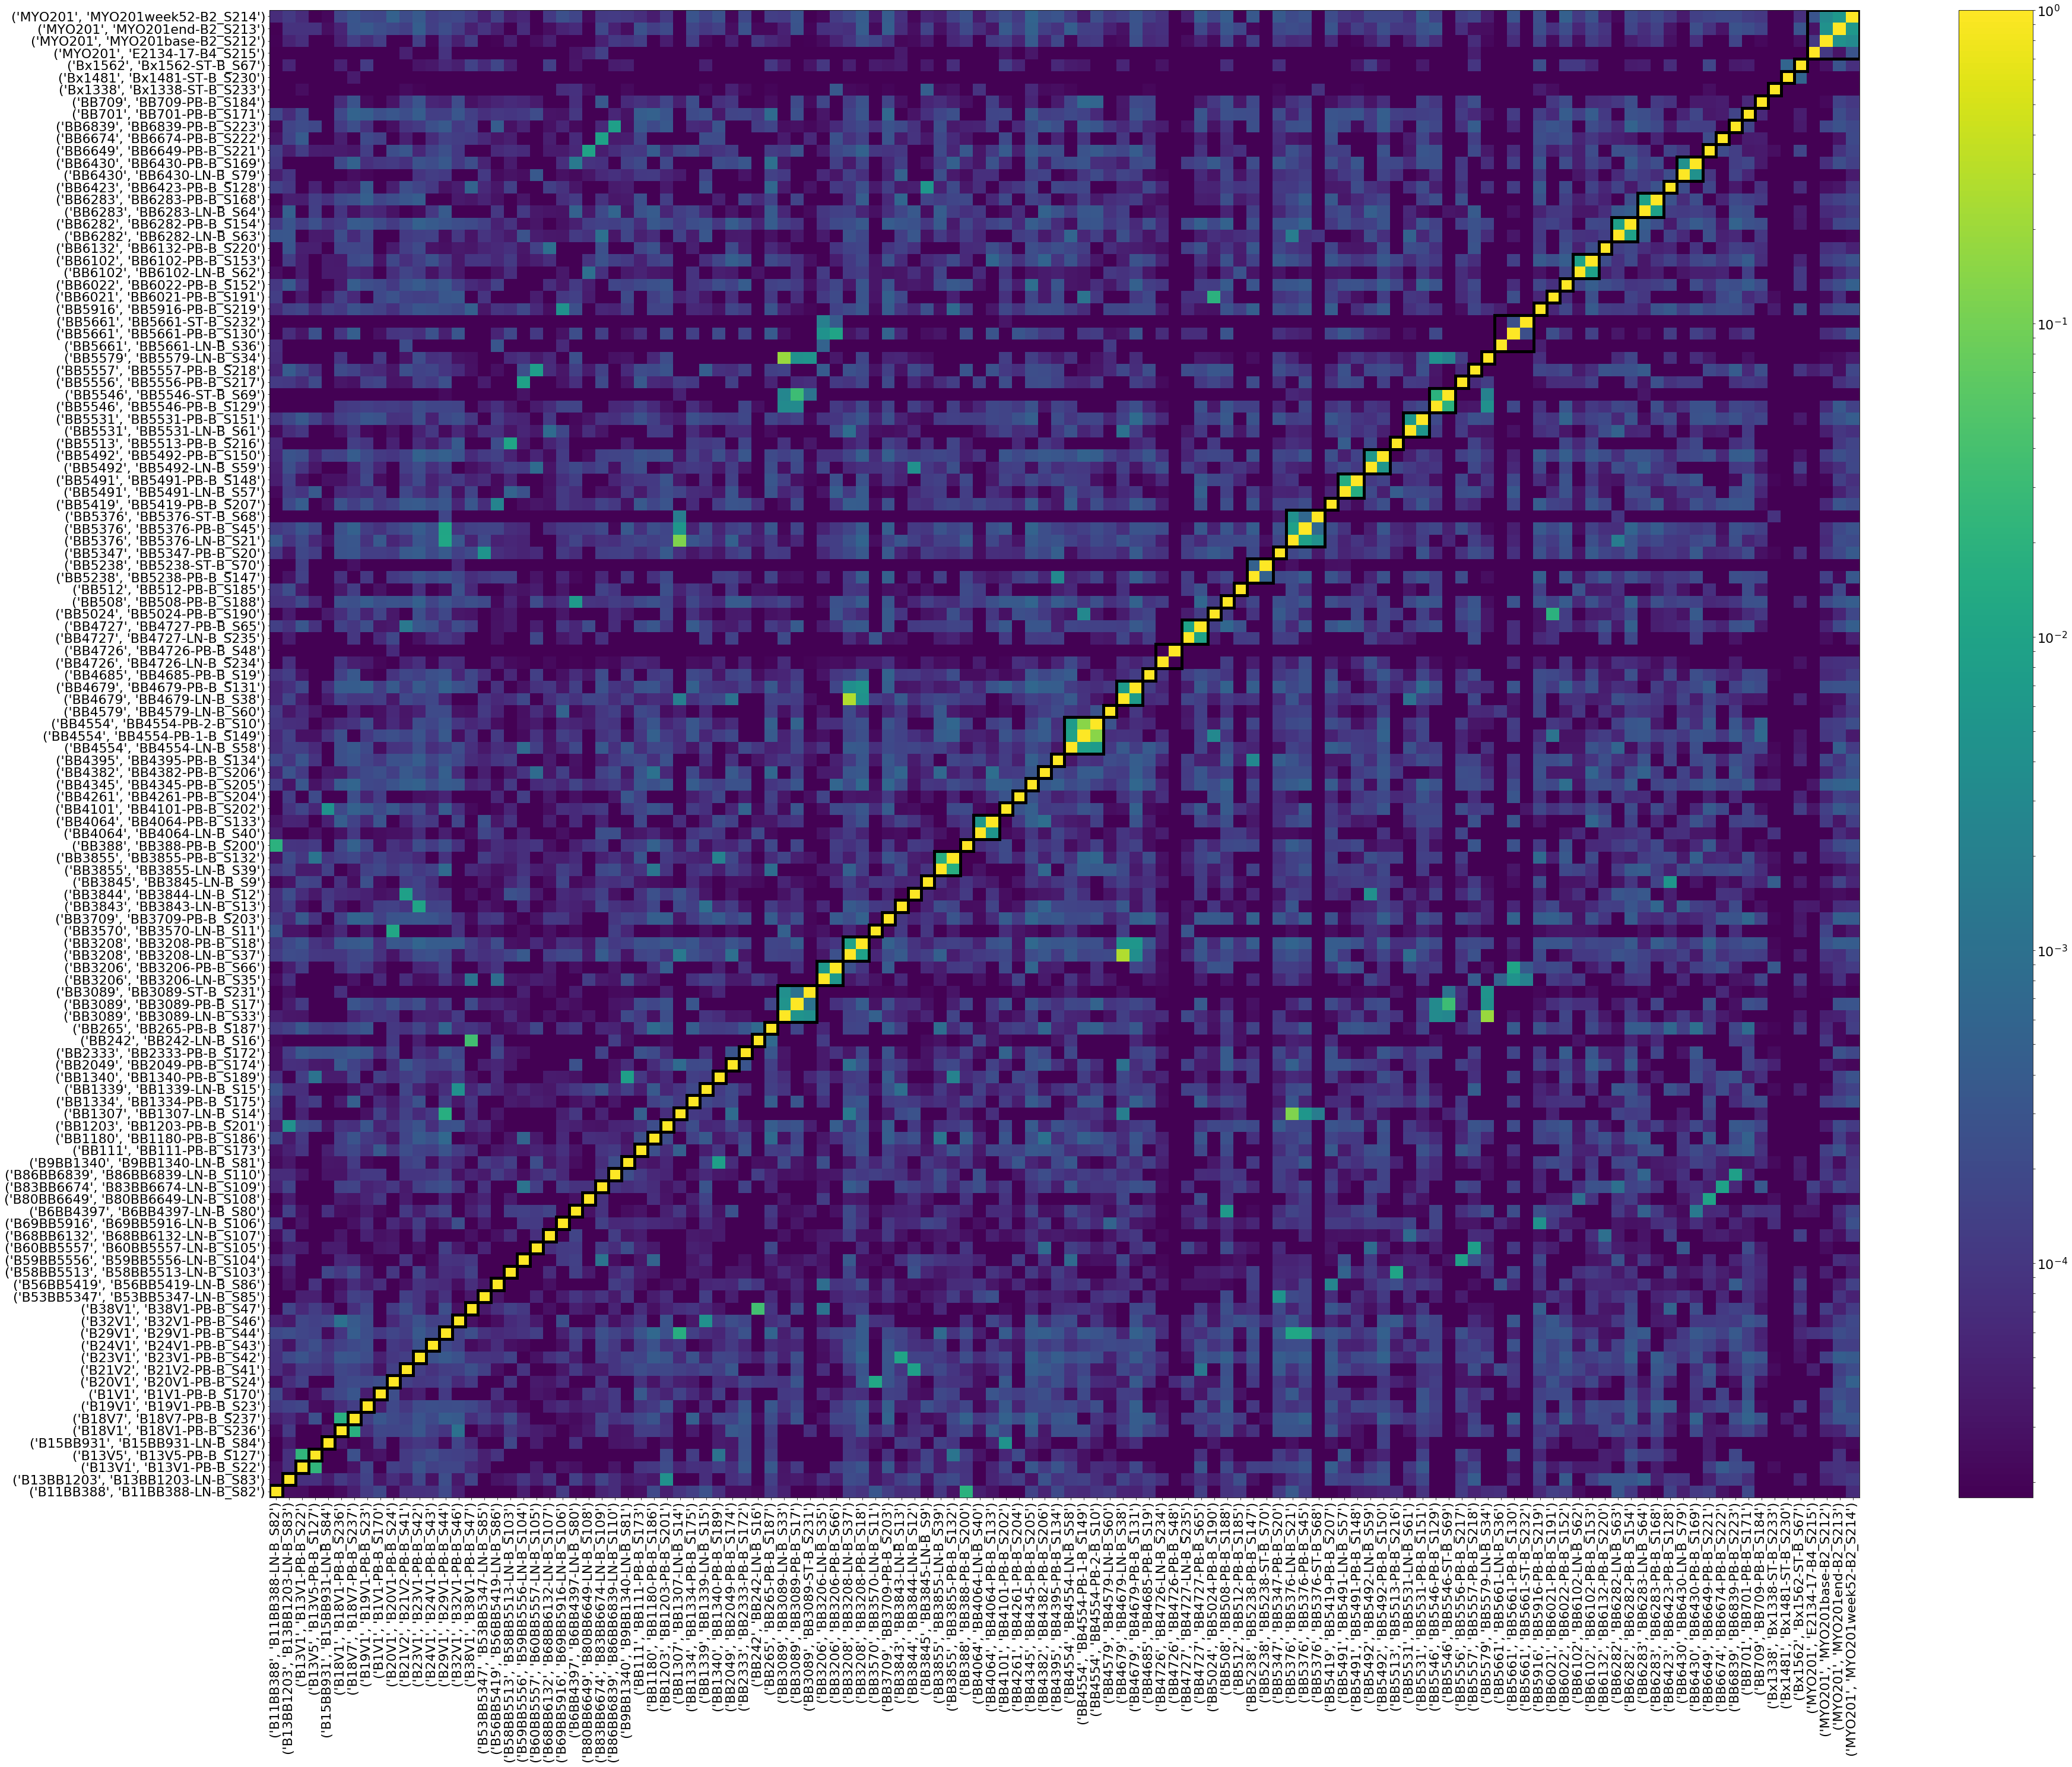

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.009780945013834882 0.024118688998827482
mean diff patient 0.00023055504869170758 0.00415550245743213
threshold 0.016852564878420226


{'whiskers': [<matplotlib.lines.Line2D at 0x7f18dcf14668>,
 'caps': [<matplotlib.lines.Line2D at 0x7f18dcf14f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f18dcf14518>,
 'medians': [<matplotlib.lines.Line2D at 0x7f18dcf1a7b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f18dcf1abe0>,
 'means': []}

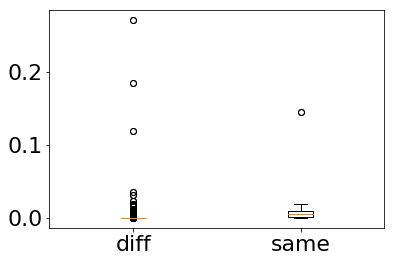

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

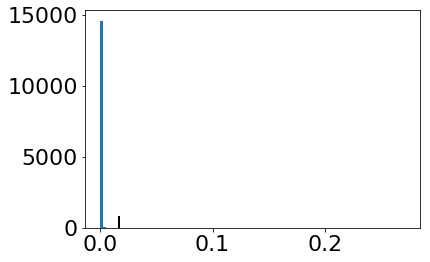

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('B11BB388', 'B11BB388-LN-B_S82') ('BB388', 'BB388-PB-B_S200') 0.019465089784625356
('B13V1', 'B13V1-PB-B_S22') ('B13V5', 'B13V5-PB-B_S127') 0.022726372886724522
('B13V5', 'B13V5-PB-B_S127') ('B13V1', 'B13V1-PB-B_S22') 0.022726372886724522
('B18V1', 'B18V1-PB-B_S236') ('B18V7', 'B18V7-PB-B_S237') 0.01781430950453
('B18V7', 'B18V7-PB-B_S237') ('B18V1', 'B18V1-PB-B_S236') 0.01781430950453
('B38V1', 'B38V1-PB-B_S47') ('BB242', 'BB242-LN-B_S16') 0.03591444871698213
('BB1307', 'BB1307-LN-B_S14') ('BB5376', 'BB5376-LN-B_S21') 0.1187245211369855
('BB242', 'BB242-LN-B_S16') ('B38V1', 'B38V1-PB-B_S47') 0.03591444871698213
('BB3089', 'BB3089-LN-B_S33') ('BB5579', 'BB5579-LN-B_S34') 0.18448495871162673
('BB3089', 'BB3089-PB-B_S17') ('BB5546', 'BB5546-ST-B_S69') 0.031811720675819166
('BB3208', 'BB3208-LN-B_S37') ('BB4679', 'BB4679-LN-B_S38') 0.27025171211217724
('BB388', 'BB388-PB-B_S200') ('B11BB388', 'B11BB388-LN-B_S82') 0.019465089784625356
('BB4679', 'BB4679-LN-B_S38') ('BB3208', 'BB3208-LN-B_

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.7886687832535664e-05
max value: 1.0
Wrote run41-similarity-IGH_HUMAN-highlighted.pdf to disk


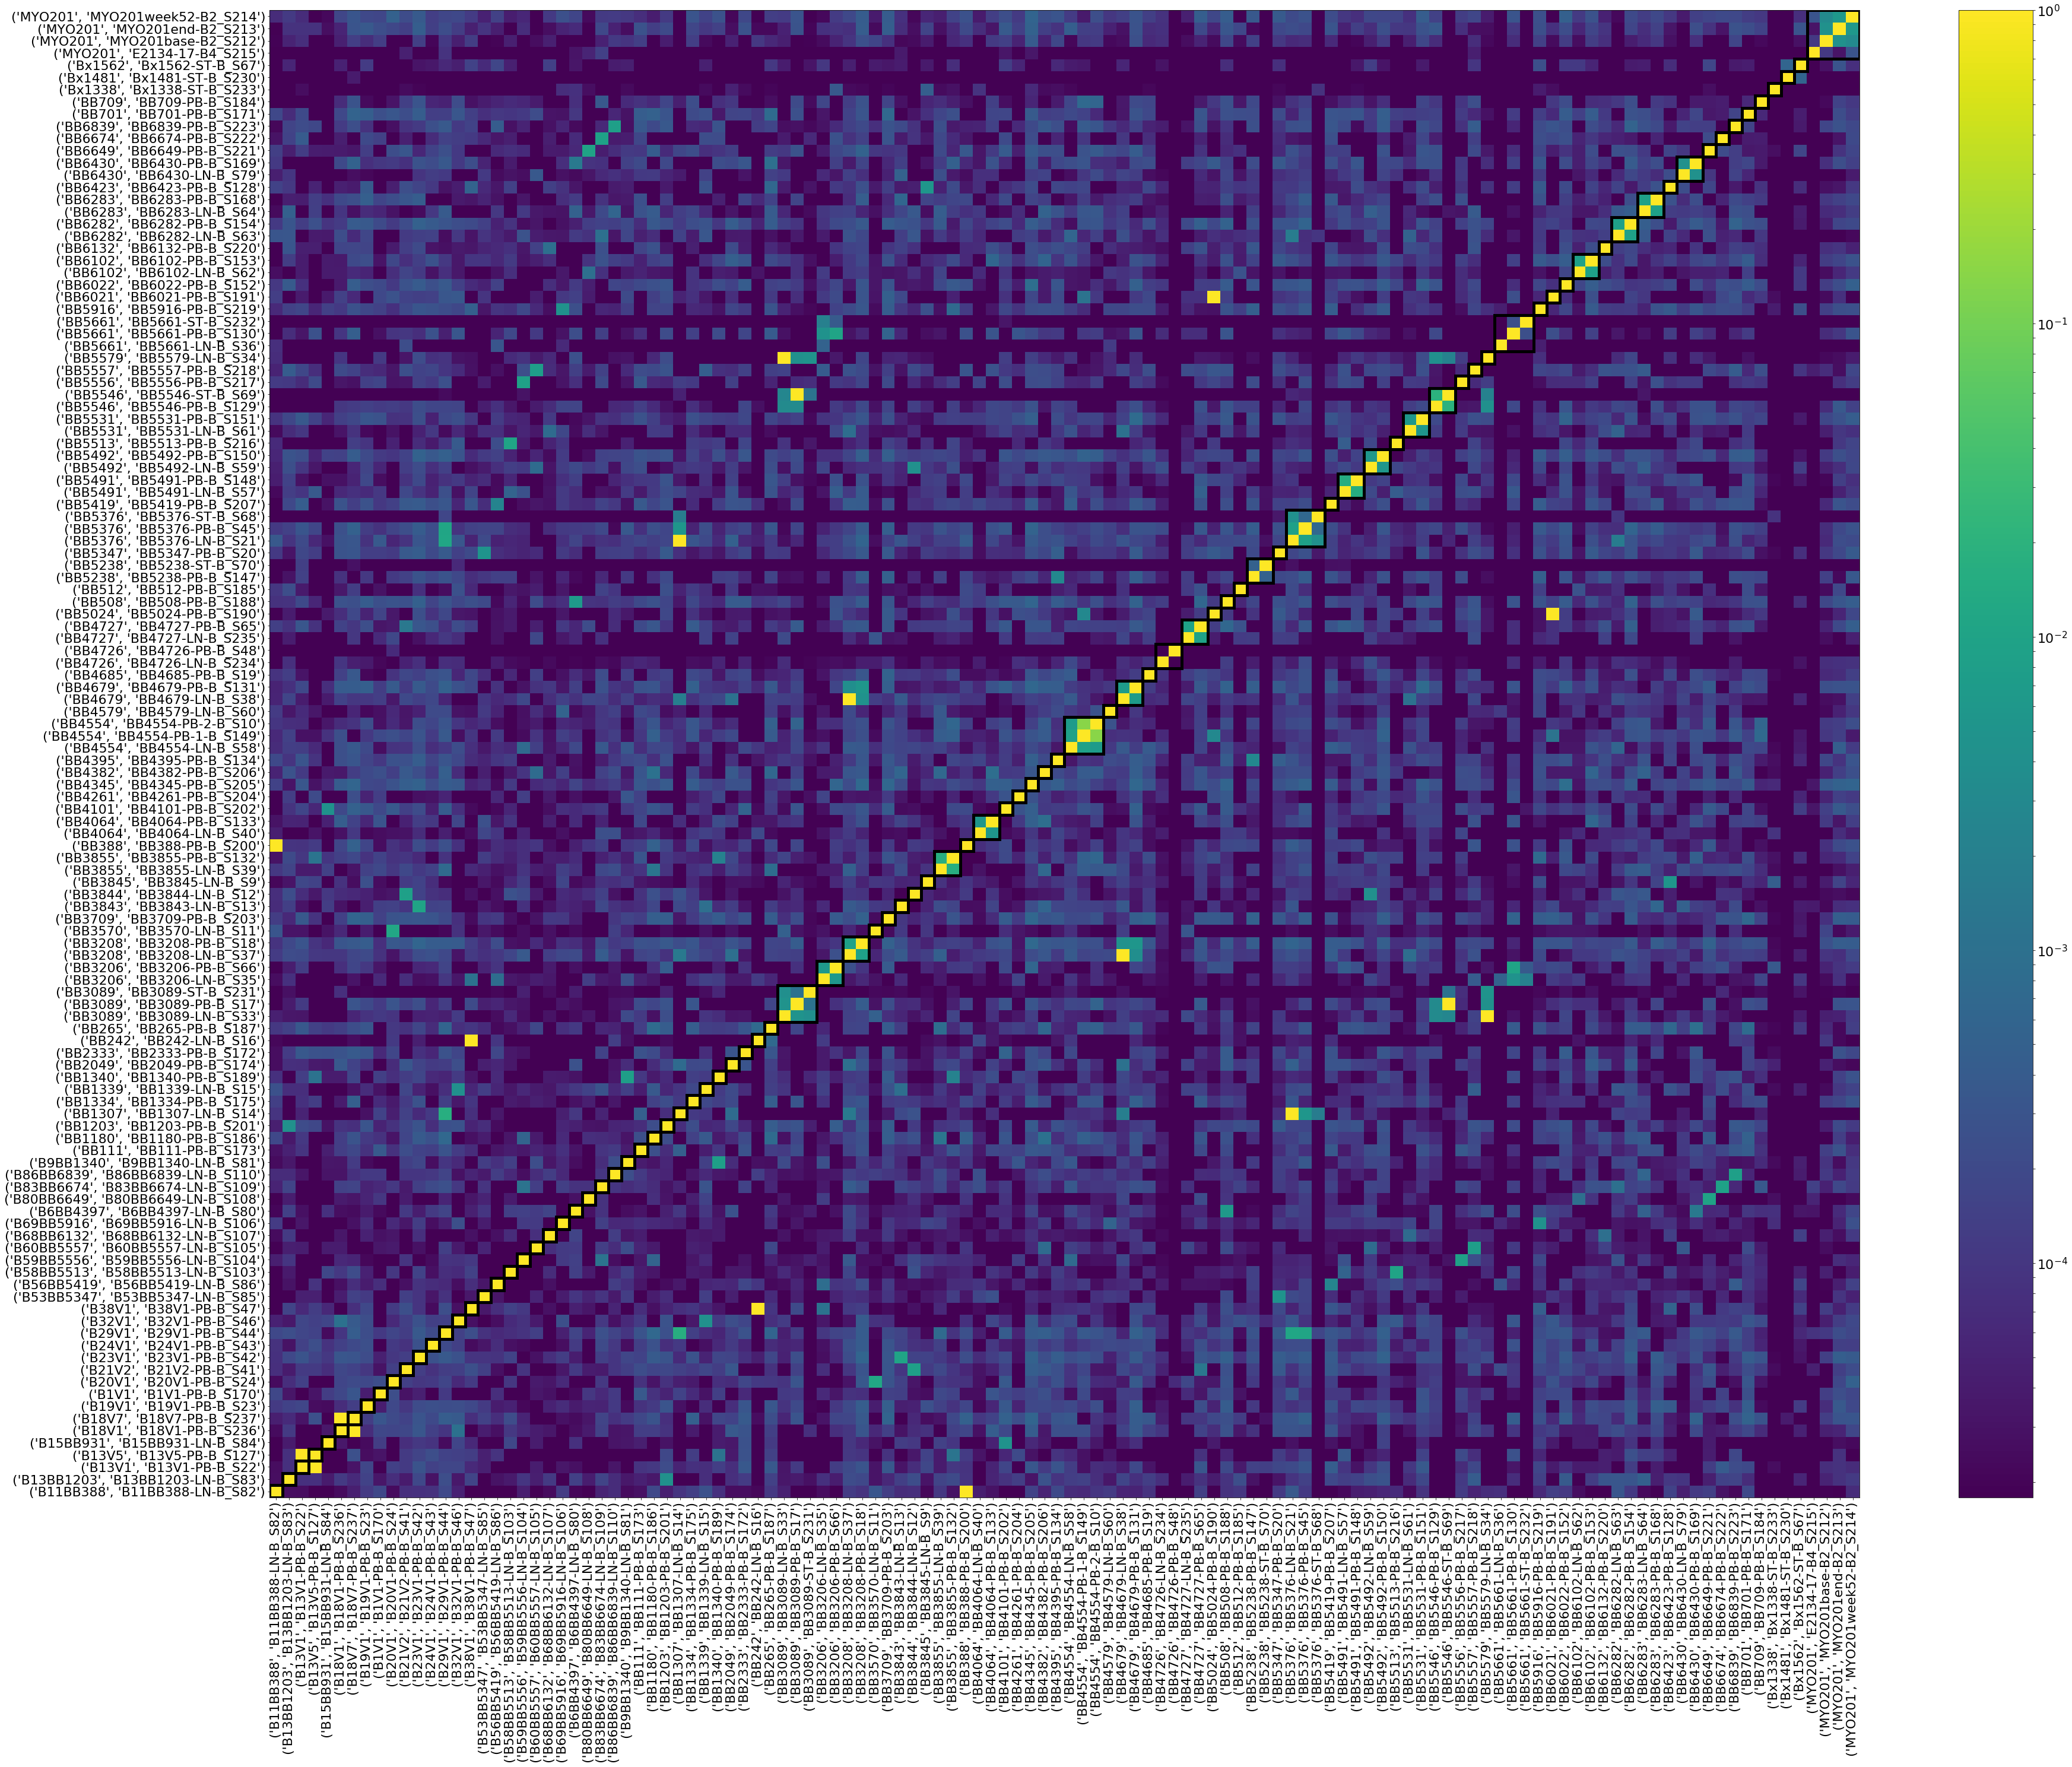

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)